# Toggle_Switch

In [1]:
import numpy as np
import gillespy2
from gillespy2.core import Model, Species, Reaction, Parameter, RateRule


In [2]:
class Toggle_Switch(Model):
    def __init__(self, parameter_values=None):
        Model.__init__(self, name="Toggle_Switch")
        self.volume = 1

        # Parameters
        self.add_parameter(Parameter(name="alpha1", expression=1))
        self.add_parameter(Parameter(name="alpha2", expression=1))
        self.add_parameter(Parameter(name="beta", expression=2))
        self.add_parameter(Parameter(name="gamma", expression=2))
        self.add_parameter(Parameter(name="mu", expression=1))

        # Species
        self.add_species(Species(name="A", initial_value=10, mode="dynamic"))
        self.add_species(Species(name="B", initial_value=10, mode="dynamic"))

        # Reactions
        self.add_reaction(Reaction(name="cu", reactants={}, products={'A': 1}, propensity_function="alpha1/(1+pow(B, beta))"))
        self.add_reaction(Reaction(name="cv", reactants={}, products={'B': 1}, propensity_function="alpha2/(1+pow(A, gamma))"))
        self.add_reaction(Reaction(name="du", reactants={'A': 1}, products={}, rate=self.listOfParameters["mu"]))
        self.add_reaction(Reaction(name="dv", reactants={'B': 1}, products={}, rate=self.listOfParameters["mu"]))

        # Timespan
        self.timespan(np.linspace(0, 250, 251))

In [3]:
model = Toggle_Switch()

In [4]:
results = model.run(seed=None)

In [5]:
results.plotplotly()

In [6]:
# Feature extraction function.  What value(s) do you want to extract
# from the simulation trajectory

def population_at_last_timepoint(c,res):
    if c.verbose: print('population_at_last_timepoint {0}={1}'.format(c.species_of_interest,result1[c.species_of_interest][-1]))
    return res[c.species_of_interest][-1]

# Aggregation function, How to we combine the values from multiple 
# trajectores

def mean_std_of_ensemble(c,data):
    a=np.average(data)
    s=np.std(data)
    if c.verbose: print('mean_std_of_ensemble m:{0} s:{1}'.format(a,s))
    return (a,s)

In [7]:
class ParameterSweep1D():
    
    def run(c, verbose=False):
        c.verbose = verbose
        fn = c.feature_extraction
        ag = c.ensemble_aggragator
        data = np.zeros((len(c.p1_range),2))# mean and std
        for i,v1 in enumerate(c.p1_range):
            tmp_model = c.ps_class()
            tmp_model.listOfParameters[c.p1].set_expression(v1)
            if verbose: print("running {0}={1}".format(c.p1,v1))
            #if verbose: print("\t{0}".format(["{0}={1}, ".format(k,v.value) for k,v in tmp_model.listOfParameters.items()]))
            if(c.number_of_trajectories > 1):
                tmp_results = tmp_model.run(number_of_trajectories=c.number_of_trajectories)
                (m,s) = ag([fn(x) for x in tmp_results])
                data[i,0] = m
                data[i,1] = s
            else:
                tmp_result = tmp_model.run()
                data[i,0] = c.feature_extraction(tmp_result)
        c.data = data
        
    def plot(c):
        from matplotlib import pyplot as plt
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        import numpy
        fig, ax = plt.subplots(figsize=(8,8))
        plt.title("Parameter Sweep - Species: {0}".format(c.species_of_interest))
        plt.errorbar(c.p1_range,c.data[:,0],c.data[:,1])
        plt.xlabel(c.p1, fontsize=16, fontweight='bold')
        plt.ylabel("Population", fontsize=16, fontweight='bold')
    

In [8]:
# Configuration for the Parameter Sweep
class ParameterSweepConfig(ParameterSweep1D):
    # What class defines the GillesPy2 model
    ps_class = Toggle_Switch
    # What is the first parameter we will vary
    p1 = 'alpha1'
    p1_range = np.linspace(1,10,10)
    number_of_trajectories = 100
    
    species_of_interest = 'A'
    # What feature of the simulation are we examining
    feature_extraction = population_at_last_timepoint
    # for number_of_trajectories > 1: how do we aggreggate the values
    ensemble_aggragator = mean_std_of_ensemble


In [9]:
ps = ParameterSweepConfig();
%time ps.run()

CPU times: user 314 ms, sys: 134 ms, total: 448 ms
Wall time: 20.1 s


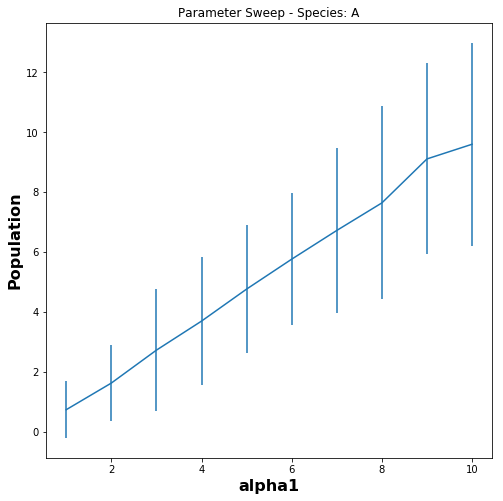

In [11]:
ps.plot()